# The dataset

The focus of this analysis is pre-monsoon water quality in Telangana. The data may be found [here](https://data.telangana.gov.in/dataset/telangana-ground-water-department-pre-monsoon-water-quality-data). Using data from 2020, the concentration of various minerals and molecules identified in water are used to predict the electrical conductivity (EC) of the sample. For determining the composition of a water sample, understanding how the presence of each analyte affects the overall EC of the sample allows us to compare the predicted EC with the measured conductivity. A strong mismatch could indicate the presence of an analyte not included in the assay. Such samples could then be screened with an assay spanning more component compounds. The advantage is that more detailed analysis, requiring more resources, would only be reserved for samples that have this mismatch, effectively allowing us to screen samples for the presence of common / less-common analytes. This is especially relevant in Telangana, where water quality varies greatly across the state, and testing resources are relatively limited.

In [260]:
#importing libraries 
import numpy as np 
import pandas as pd 
import scipy.stats as sts
import matplotlib.pyplot as plt 
import seaborn as sns
import pymc as pm
import arviz as az 

In [261]:
#importing the data 
water = pd.read_csv('water_20.csv')
keep = ['TDS', 'E.C', 'Na','Ca','K','F','HCO3','Cl','NO3 ','SO4','CO3']
#keeping only the columns of interest
water = water[keep]

#dropping na values
water.dropna().reset_index(drop = True)

TDS     E.C      Na   Ca      K     F  HCO3    Cl        NO3   \
0    1069.44  1671.0  154.00   72  13.00  0.51   470   230    3.422409   
1     348.80   545.0   94.00   16  12.00  1.08   180    80    4.227682   
2     472.32   738.0   22.00   40   1.00  0.45   220    30   28.385864   
3     738.56  1154.0   81.00   56   3.00  0.69   300   100  140.922727   
4     666.88  1042.0   39.00   96   4.00  0.72   370    30  163.067727   
..       ...     ...     ...  ...    ...   ...   ...   ...         ...   
350  1410.56  2204.0  148.00  144   2.00  1.11   290   300  436.699400   
351   872.32  1363.0  119.00   72   5.39  2.23   380   170   35.609160   
352   453.12   708.0   43.55   56   2.77  2.30   290    40   14.704280   
353  3121.92  4878.0  532.00  400   7.30  0.80   350  1380   36.893570   
354  1032.96  1614.0   94.00  152   3.74  1.77   250   350   44.998640   

        SO4  CO3  
0     31.50    0  
1     13.00    0  
2      9.50    0  
3     14.75    0  
4     10.25    0  
..      ...  ...  
350   32.00    0  
351   25.00    0  
352   10.00    0  
353  105.00    0  
354   22.00    0  

[355 rows x 11 columns]

Pearsons r:  0.9999999999999998


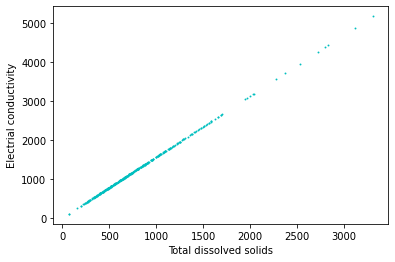

In [262]:
#visualising TDS vs EC 
plt.scatter(water['TDS'], water['E.C'], s = 0.8, color = 'c')
plt.xlabel('Total dissolved solids')
plt.ylabel('Electrial conductivity')
r = sts.pearsonr(water['TDS'], water['E.C'])
print('Pearsons r: ', r[0])

The figure above shows the perfect correlation ($r = 1.0$) between total dissolved solids and EC. Since only ions contribute to the electrical conductivity of the sample, the total dissolved solids would account perfectly for EC, and this is exemplified in the figure above. Note that total dissolved solids is **not** the same as the sum of all the analytes - only a subset of dissolved solids were quantified in this dataset.

# Model 1: Non-Robust Linear Regression

The goal of this regression is to understand the relative cotribution of each analyte to the overal electrical conductivity of the sample. Doing so, we can use the regression model to predict the EC of a new sample, and compare this with the measured conductivity. This would provide evidence for the presence of other, rarer analytes which may warrant further analysis. For example, certain pharmaceuticals are charged and also effect the conductivity of water, and their presence in the water supply could pose a public health and environmental hazard.  

This first model uses non-robust linear regression, with EC as the target and the concentrations of each analyte provided in the data the predictor variables. The model is defined as follows: 
$$
\begin{align*}
    \alpha &\sim \text{Normal}(200, 75)\\
    \beta_k &\sim \text{Normal}(0,10)\\
    \sigma &\sim \text{Exponential}(1)\\
    \mu_i &\sim \alpha+ \sum_{k=1}^9 \beta_k x_k\\
    \text{EC} &\sim \text{Normal}(\mu, \sigma)
\end{align*}
$$
The likelihood function is a a normal distribution of mean $\mu$ and standard deviation $\sigma$: that is to say that the electrical conductivity measurements are normally distributed with random sampling of the groundwater. $\sigma$ is Expon(1) distributed. The Expon(1) distribution has thicker tails than $\Phi(1)$, and penalises higher $\sigma$ values less. The mean $\mu$ is estimated using the measured concentrations of various analytes. Each variable linearly predicts EC, which is to say that all ions affect EC the same way. 

The coefficients $\beta_k$ measure the relative impact of each on the electric conductivity of the sample, and the intercept $\alpha$ the conductivity of pure water. The priors on $\beta_{k}$ are Normal(0,10). This is a very flat prior that allows for both positive and negative coefficients. The prior on $\alpha$ reflects my past knowledge of typical concentrations of particulate matter. I know that bottled water typically has ppm concentrations <50, but that the water used in this analysis is untreated groundwater, and that ppm values will generally be in the low hundreds.


In [263]:
#standardising the data
for i in keep: 
    water.loc[: , i+'_std'] = (
    (water.loc[:, i] - water.loc[:, i].mean()) /
    water.loc[:, i].std())

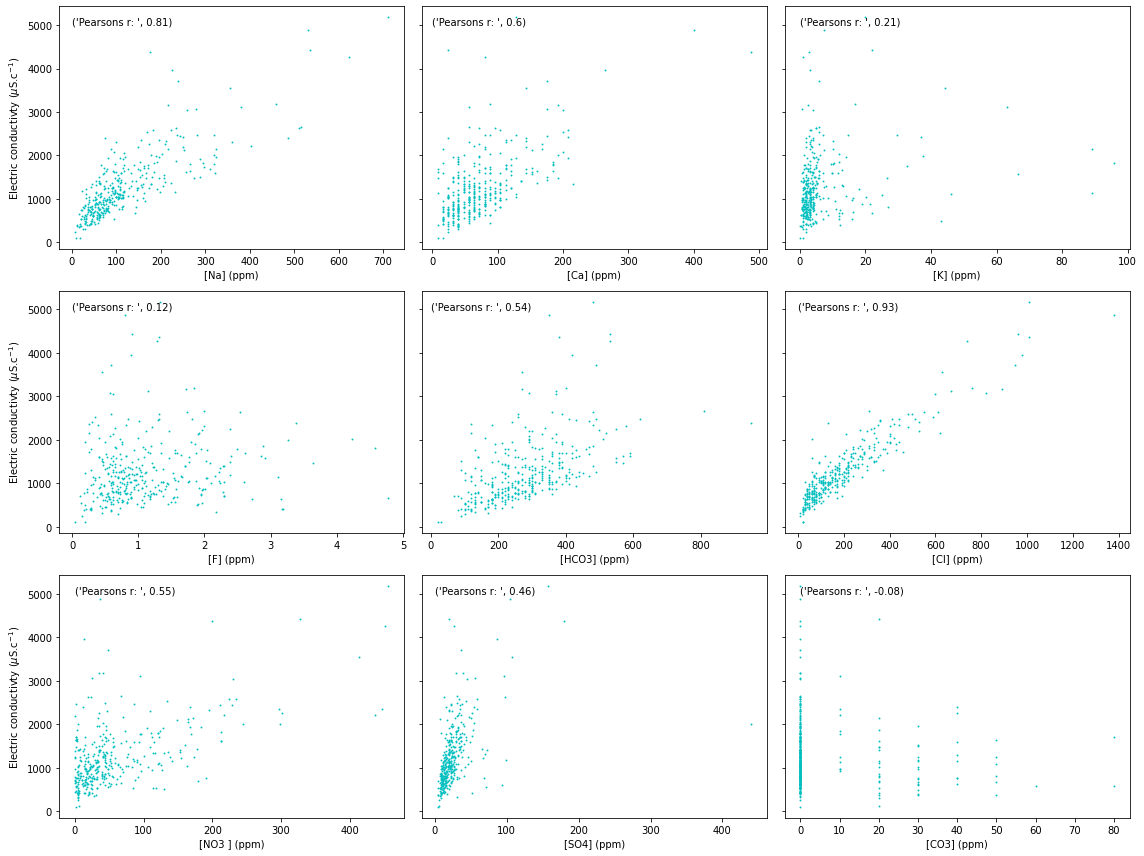

In [264]:
fig, ax = plt.subplots(3, 3, sharey = 'row', figsize = (16,12))
keep = ['Na','Ca','K','F','HCO3','Cl','NO3 ','SO4','CO3']
for i in range(len(keep)):
    plt.subplot(3,3,i+1)
    plt.scatter(water[keep[i]], water['E.C'], s = 0.8, color = 'c',label = i)
    r = sts.pearsonr(water[keep[i]], water['E.C'])
    plt.text(x = 0, y = 5000, s= ('Pearsons r: ', round(r[0],2)))
    if i+1 == 1 or i+1 == 4 or i+1 == 7:
        plt.ylabel('Electric conductivty ($\mu$S.c$^{-1}$)')
    plt.xlabel('[' + keep[i] + '] (ppm)')
fig.tight_layout()

The scatter plots above show the relationship between each solute and the electrical conductivity of the water, as well as their Pearson's r coefficients. Not all solutes are strongly correlated with EC: Only sodium, chlorine and sulphate have $r>0.8$. However, other plots have a visibly linear relationships, but contain many outliers. 

In choosing predictor variables, correlations are but one criterion. As this analysis concerns electrical conductivity, which is only influenced by the ions in the water, we will include several more ions in addition to Na, Cl and SO4. These are the moderately correlated NO3, HCO3 and Ca. Other ions are in concentrations too low to bear any strong influence on electric conductivity. 

Remember that the purpose of this analysis is to flag samples for further analysis. Because the poorly correlated ions are in very low concentrations (e.g. [F]<5 ppm), the data is subject to a lot of noise from all of the other, much more concentrated solutes. Thus by also including moderately correlated ions, we limit overfitting by excluding ions subject to this noise, but also account for ions present in non-negligible concentrations. If we some of these ions were left out, we'd be flagging samples likely to contain normal solutes. 

In [265]:
#in this cell the model is implemented
keep = ['Na_std','Ca_std','HCO3_std','Cl_std','NO3 _std','SO4_std']
n = len(keep)
data_x = np.array(water[keep])

n_samples = 2000
with pm.Model() as m1: 
    #priors 
    alpha = pm.Normal('alpha',200,75) #prior knowledge that ppms are generally in the low 100s
    beta = pm.Normal('beta',0,10, shape = n)
    sigma = pm.Exponential('sigma',1)
    
    #likelihood
    mu = pm.Deterministic('mu', beta[0]*water['Na_std'] + beta[1]*water['Ca_std'] + 
                          beta[2]*water['HCO3_std']+beta[3]*water['Cl_std']+
                          beta[4]*water['NO3 _std']+beta[5]*water['SO4_std'])
    EC = pm.Normal('EC', mu = mu, sigma = sigma, observed = water['E.C_std'])
    
    #sampling 
    trace_m1 = pm.sample(n_samples, idata_kwargs = {'log_likelihood': True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


In [266]:
#prior summary
varnames = ['~mu']
with m1: 
    inference = pm.sample_prior_predictive(n_samples)
az.summary(inference, var_names = varnames)

Sampling: [EC, alpha, beta, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma      0.995   0.987   0.000    2.847      0.023    0.016    1888.0   
beta[0]   -0.224   9.641 -18.066   16.550      0.230    0.163    1776.0   
beta[1]    0.197   9.894 -17.185   20.293      0.223    0.162    1973.0   
beta[2]    0.288   9.928 -19.270   18.056      0.237    0.168    1754.0   
beta[3]    0.052   9.727 -18.320   18.676      0.221    0.156    1943.0   
beta[4]    0.292  10.130 -19.602   18.173      0.225    0.169    2022.0   
beta[5]   -0.041  10.047 -19.449   17.876      0.234    0.166    1854.0   
alpha    200.369  76.505  61.485  344.395      1.782    1.261    1827.0   

         ess_tail  r_hat  
sigma      1891.0    NaN  
beta[0]    2003.0    NaN  
beta[1]    1918.0    NaN  
beta[2]    1847.0    NaN  
beta[3]    1962.0    NaN  
beta[4]    1960.0    NaN  
beta[5]    1786.0    NaN  
alpha      1679.0    NaN

Examining the prior distribution of the parameters provides us with a sanity check for our model. Looking at the 94\% HDI over each parameter, we see that they approximately span the range (-20,20): coefficients may be quite steep or quite flat, and are equally likely to be either positive or negative. This lack of information is expected of a prior distribution

In [267]:
#diagnostic summary 
varnames = ['~mu'] #all variables except mu
az.summary(trace_m1, varnames)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    199.401  74.558  61.581  342.871      0.756    0.553    9733.0   
beta[0]    0.048   0.012   0.024    0.070      0.000    0.000    3071.0   
beta[1]   -0.000   0.009  -0.017    0.016      0.000    0.000    3494.0   
beta[2]    0.296   0.008   0.281    0.311      0.000    0.000    3875.0   
beta[3]    0.708   0.012   0.686    0.730      0.000    0.000    3626.0   
beta[4]    0.179   0.006   0.168    0.191      0.000    0.000    6234.0   
beta[5]    0.080   0.006   0.069    0.091      0.000    0.000    7378.0   
sigma      0.098   0.004   0.091    0.105      0.000    0.000    8643.0   

         ess_tail  r_hat  
alpha      6079.0    1.0  
beta[0]    4126.0    1.0  
beta[1]    4704.0    1.0  
beta[2]    5211.0    1.0  
beta[3]    5231.0    1.0  
beta[4]    5752.0    1.0  
beta[5]    5767.0    1.0  
sigma      5982.0    1.0

A look at the posterior summary tells us both about the posterior on the parameters, and whether the sampling algorithm executed successfully. For the latter, we look at the ESS and $\hat{R}$. The ESS should be at least 10\% of the sample size. With 2000 samples per chain and 4 chains, we are well above that. This implies that the samples in a chain were minimally correlated, as is expected of a Markov random walk. As for $\hat{R}$, this statistic tells us whether the sampling algorithm converged successfully. If $\hat{R}>1.01$, this suggests that the convergence failed. Here, $\hat{R}_\theta = 1$ values for all $\theta \in \Theta$, so the statistics suggest both successful convergence and low correlation within samples. 

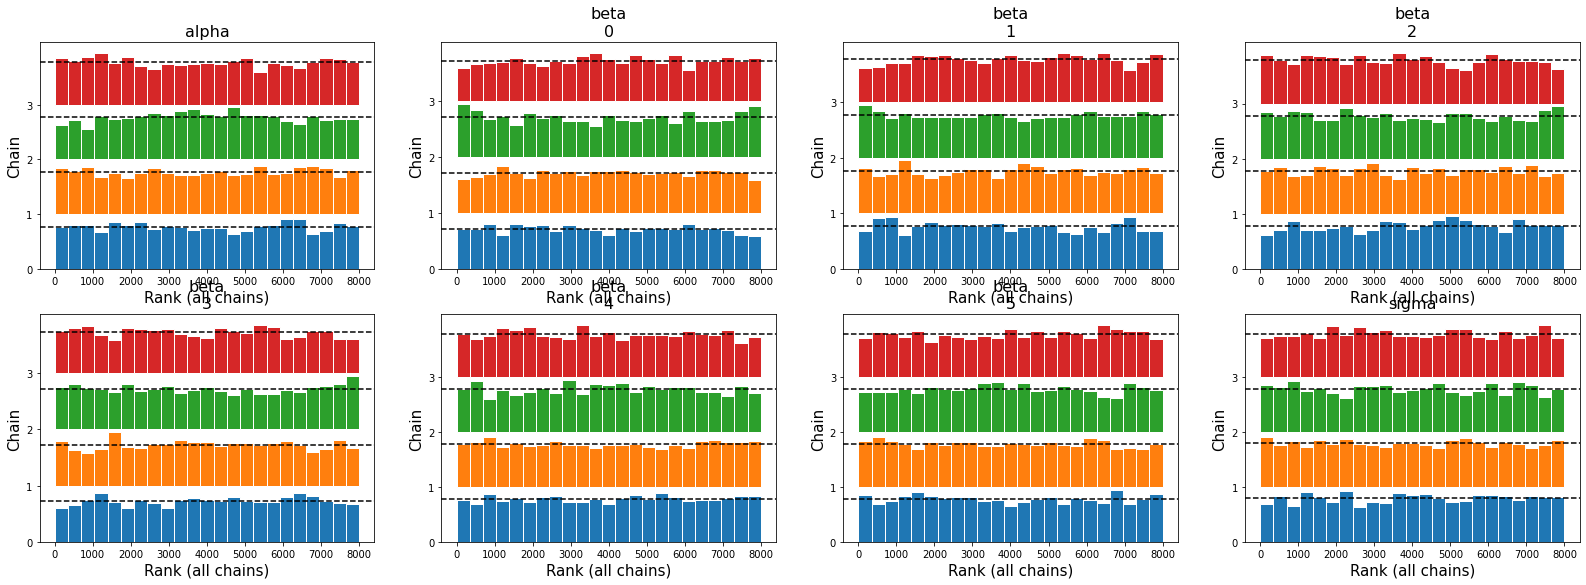

In [268]:
az.plot_rank(trace_m1, varnames)
plt.show()

The rank plots above let us see if each chain explored the entirty of the marginal posterior on each variable. If this is true, we expect to see a unifom distribution of ranks across all chains and variables. This is generally the case, as is expected considering the ESS and $\hat{R}$ values observed in the previous cell. As the rank plots are all quite uniform, and the summary statistics are within their acceptable ranges, it seems that the sampling was done successfully

array([[<AxesSubplot: ylabel='alpha'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n1'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n2'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n3'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n4'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,


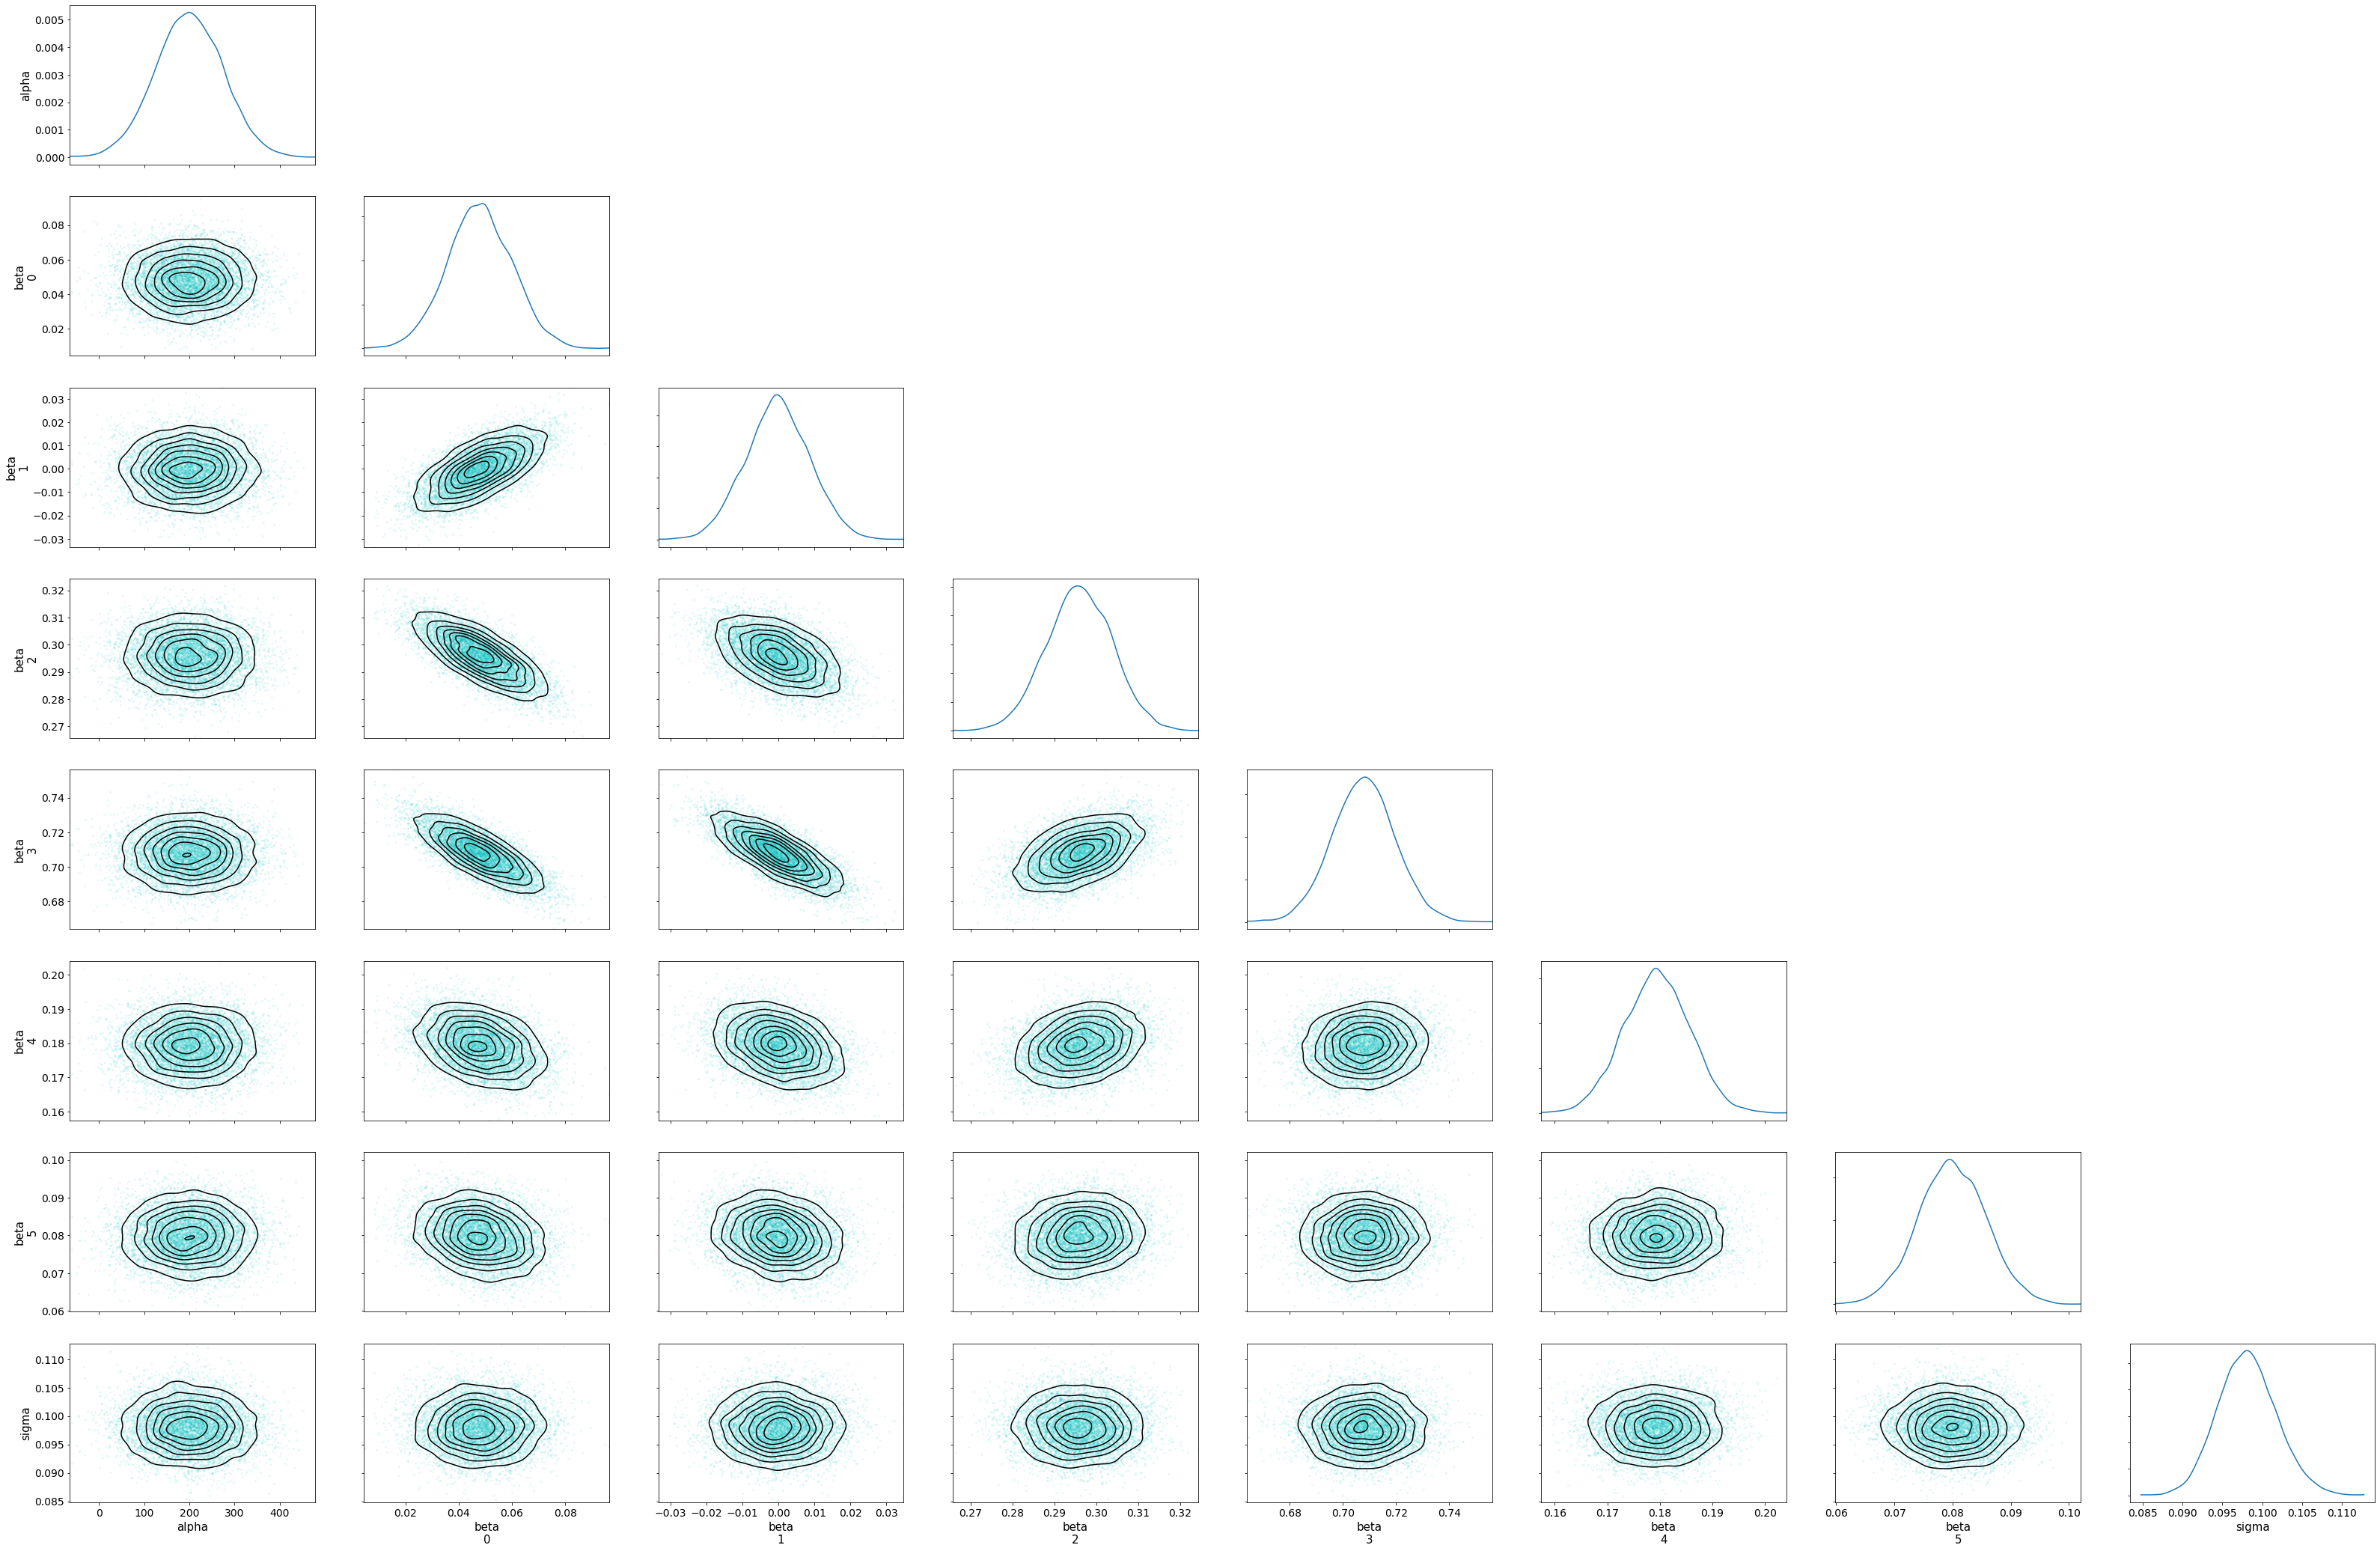

In [269]:
az.plot_pair(trace_m1, 
            var_names = varnames,
            marginals = True,
            kind = ['scatter', 'kde'],
            scatter_kwargs={"color": "c", "alpha": 0.1},
            marginal_kwargs={"kind": "kde", "color": "C0"},
            kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}})

A look at the pair plots helps us to compare the samples posterior distributions with what we expect to see. Each of the pair distrbutions are symmetrically distributed about the mean, which is what was expected; the pair plots also show no evidence of sampling issues. Note that nearly all of the coefficients are positive. Scrutiny of the pair plots shows that this isn't the case for $\beta_5$, but that's made much clearer in the figure below. 

Text(0, 0.5, 'Coefficient')

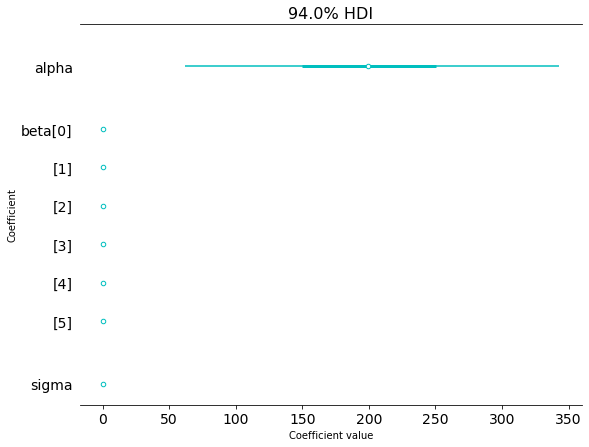

In [270]:
#94% HDIs over the parameters
az.plot_forest(trace_m1, 
              kind = 'forestplot',
               var_names = varnames,
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Coefficient value')
plt.ylabel('Coefficient')

The figure above shows the posterior 94\% HDIs for each coefficient. Notice that $\alpha$, which represents the electrical conductivity in the absence of the measured anions, has a wide HDI ([63,140]). This reflects the fact that many other solutes beyond those collected, including those excluded from the data, also impact the electrical conductivity of the water.

[Text(0, 0.0, 'Na_std'),
 Text(0, 0.825, 'Ca_std'),
 Text(0, 1.65, 'HCO3_std'),
 Text(0, 2.4749999999999996, 'Cl_std'),
 Text(0, 3.3, 'NO3 _std'),
 Text(0, 4.125, 'SO4_std')]

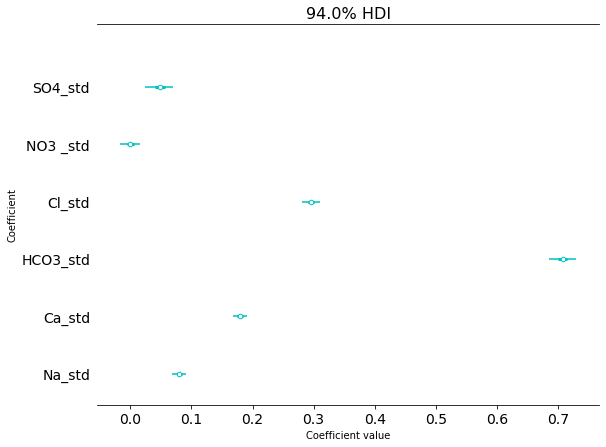

In [271]:
ax = az.plot_forest(trace_m1, 
              kind = 'forestplot',
               var_names = ['~mu','~sigma','~alpha'],
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Coefficient value')
plt.ylabel('Coefficient')
ax[0].set_yticklabels(keep)


A look at the HDIs for $\beta_k$ shows us that each solute has a different impact on the overall E.C of the solution. There is some overlap in the coefficients for SO4 and NO3, but NO3 generally has a smaller contribution. Note also that the HDI for NO3 enters negative coefficient values, which is to say that the model thinks that it could sometimes decrease the conductivity of the water sample. This is physically impossible, and reflects the small-world knowledge of the model. The NO3 data is highly heteroscedastic and contains many outliers, and a robust model may improve on this issue. 

The narrow posterior HDIs suggest that the electrical conductivity can be estimated quite precisely using only data on these select analytes, useful for our purpose of flagging samples with E.C above what is predicted. The posterior over sigma is also incredibly narrow, meaning that the E.C. values are measured with very high precision Let's now look at some posterior predictive samples.

Text(0, 0.5, 'Coefficient')

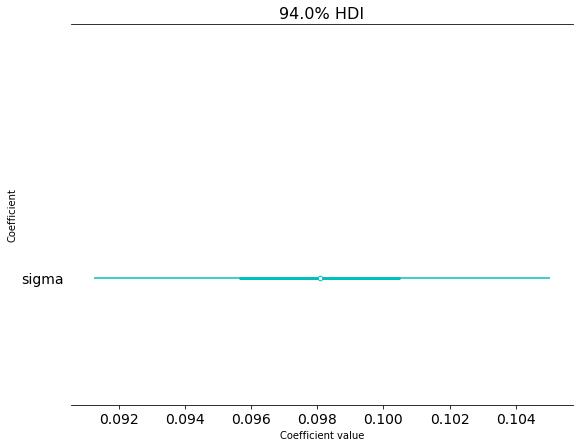

In [291]:
ax = az.plot_forest(trace_m1, 
              kind = 'forestplot',
               var_names = ['sigma'],
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Coefficient value')
plt.ylabel('Coefficient')

In [273]:
#posterior predictive 

#sampling from the posterior predictive
n_samples = 6 #number of samples to draw 

with m1: 
    pos = pm.sample(6)

#taking posterior samples
samples = [pos.posterior.mu.values.flatten(), pos.posterior.sigma.values.flatten()]

Only 6 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 6 draw iterations (4_000 + 24 draws total) took 20 seconds.
<ipython-input-273-bc6ed2bf6ed6>:7: UserWarning: The number of samples is too small to check convergence reliably.
  pos = pm.sample(6)


<ipython-input-274-c04cf1cd9b0d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([np.abs(round(d*water['E.C'].std(), 2)) for d in x])


Text(0.5, 0.98, 'Posterior-predictive samples')

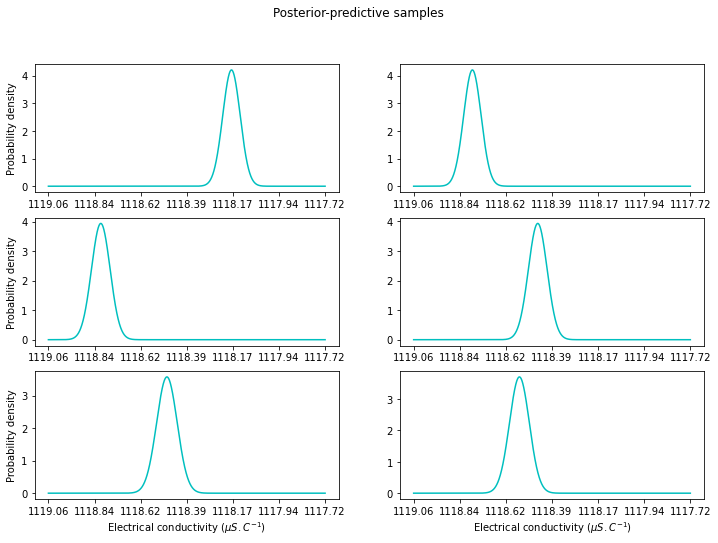

In [274]:
#plotting posterior-predictive normal distributions 
fig, axs = plt.subplots(3,2, figsize = (12,8))
#code adapted from Session 5, PCW notebook, Cell 5
for i in range(n):
    ax = plt.subplot(3,2,i+1)
    m = samples[0][i]
    s = samples[1][i]
    
    x = np.linspace(-1.5,1.5, 10000)
    y = sts.norm.pdf(x, loc = m, scale = s)
    
    plt.plot(x,y, color = 'c')
    
    #changing x scales to absolute values
    #ax.set_xticks(np.linspace(-1.5,1.5,7))
    #ax.set_xticklabels([x*water['E.C'].std()+water['E.C'].mean() for x in np.linspace(-1.5,1.5,7)])
    if i == 0 or i == 2 or i == 4: 
        plt.ylabel('Probability density')
    if i == 4 or i == 5:
        plt.xlabel('Electrical conductivity ($\mu S.C^{-1}$)')
    ax.set_xticklabels([np.abs(round(d*water['E.C'].std(), 2)) for d in x])
plt.suptitle('Posterior-predictive samples')

The plots above show six distributions of EC using means and standard deviations sampled from the posterior. As predicted, the electric conductivity can be predicted with high precision with our given set of predictor variables. This is excellent for flagging samples: we want to flag samples that are believed to contain solutes other than those chosen as analytes. Because the electric conductivity can be predicted so precisely, samples that deviate even slightly from the predicted electric conductivity will be flagged. That is to say that samples containing a very small amount of additional analyte will be flagged, giving us also high precision in detecting the presence of additional solutes and their combined concentration.

# Model 2: Robust Multivariate Regression 

This next model builds on the previous and gains robustness against outliers. The cell below shows scatter plots of each analyte's concentration and the measured electric conductivity. As is evident, there are major outliers in each plot. These outliers reduce the model's predictive power by pulling on $\sigma$ to account for their high deviation from the mean. One way to improve the regression's robustness is to use a Student T distribution, which has thicker tails than a normal distribution. The thickness of the tails are determined by a parameter $\nu$. For $\nu>30$, the T distribution converges on the normal distribution. So our second model is defined as: 
$$
\begin{align*}
    \alpha &\sim \text{Normal}(\mu = 200, \sigma = 75)\\
    \beta_k &\sim \text{Normal}(\mu = 0, \sigma = 10)\\
    \sigma &\sim \text{Exponential}(\lambda = 1)\\
    \nu &\sim \text{HalfNormal}(\sigma = 30)\\
    \mu_i &\sim \alpha+ \sum_{k=1}^9 \beta_k x_k\\
    \text{EC} &\sim \text{StudentT}(\nu, \mu, \sigma)
\end{align*}
$$
All of the priors are the same as in the previous model, we have just added a new parameter, $\nu$. The prior distribution on $\nu$ is very flat with a standard deviation of 30. This allows for values of $\nu$ that give very thick tails, as well as values of $\nu$ that give a distribution converging onto a normal distribution. The addition of this parameter lets the model account for outliers by adjusting $\nu$ rather than $\sigma$, thereby increasing the precision.  

<ipython-input-275-4a941b4e8de7>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


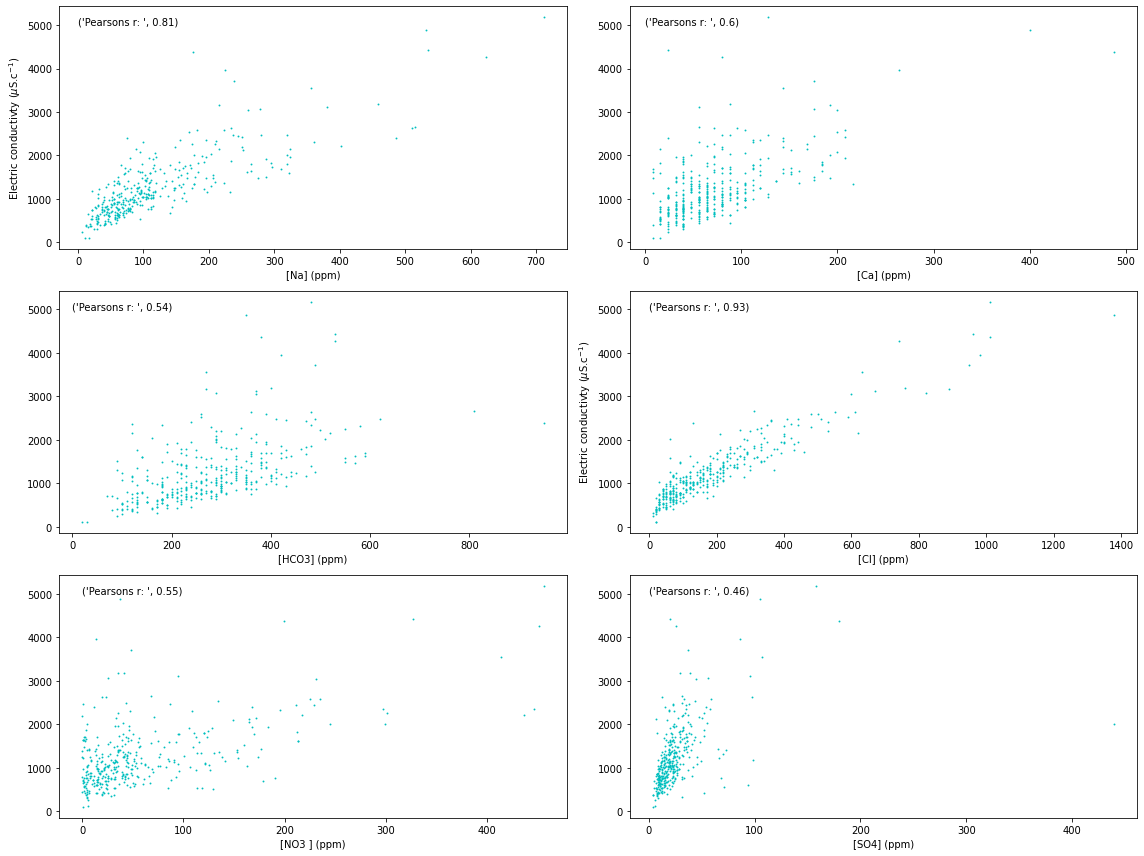

In [275]:
fig, ax = plt.subplots(3, 3, sharey = 'row', figsize = (16,12))
keep = ['Na','Ca','HCO3','Cl','NO3 ','SO4']
for i in range(len(keep)):
    plt.subplot(3,2,i+1)
    plt.scatter(water[keep[i]], water['E.C'], s = 0.8, color = 'c',label = i)
    r = sts.pearsonr(water[keep[i]], water['E.C'])
    plt.text(x = 0, y = 5000, s= ('Pearsons r: ', round(r[0],2)))
    if i+1 == 1 or i+1 == 4 or i+1 == 7:
        plt.ylabel('Electric conductivty ($\mu$S.c$^{-1}$)')
    plt.xlabel('[' + keep[i] + '] (ppm)')
fig.tight_layout()

In [276]:
#in this cell the model is implemented
keep = ['Na_std','Ca_std','HCO3_std','Cl_std','NO3 _std','SO4_std']
n = len(keep)
data_x = np.array(water[keep])

n_samples = 2000
with pm.Model() as m2: 
    #priors 
    alpha = pm.Normal('alpha',200,75) #prior knowledge that ppms are generally in the low 100s
    beta = pm.Normal('beta',0,10, shape = n)
    sigma = pm.Exponential('sigma',1)
    nu = pm.HalfNormal('nu', 30)
    #likelihood
    mu = pm.Deterministic('mu', beta[0]*water['Na_std'] + beta[1]*water['Ca_std'] + 
                          beta[2]*water['HCO3_std']+beta[3]*water['Cl_std']+
                          beta[4]*water['NO3 _std']+beta[5]*water['SO4_std'])
    EC = pm.StudentT('EC', nu = nu, mu = mu, sigma = sigma, observed = water['E.C_std'])
    
    #sampling 
    trace_m2 = pm.sample(n_samples, idata_kwargs = {'log_likelihood':True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


In [277]:
#prior summary
varnames = ['~mu']
with m2: 
    inference = pm.sample_prior_predictive(n_samples)
az.summary(inference, var_names = varnames)

Sampling: [EC, alpha, beta, nu, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma      1.041   1.035   0.001    2.905      0.024    0.017    1913.0   
beta[0]    0.228  10.111 -18.596   19.802      0.238    0.168    1803.0   
beta[1]   -0.114   9.955 -18.142   18.674      0.226    0.175    1939.0   
beta[2]    0.201   9.847 -17.299   19.507      0.231    0.163    1798.0   
beta[3]    0.399  10.150 -16.987   20.309      0.237    0.167    1838.0   
beta[4]   -0.168  10.252 -18.994   18.798      0.234    0.166    1918.0   
beta[5]   -0.395   9.922 -18.338   18.962      0.226    0.160    1926.0   
alpha    202.352  73.809  58.543  337.767      1.594    1.128    2147.0   
nu        24.878  18.484   0.052   57.095      0.427    0.302    1835.0   

         ess_tail  r_hat  
sigma      1656.0    NaN  
beta[0]    1659.0    NaN  
beta[1]    1400.0    NaN  
beta[2]    1848.0    NaN  
beta[3]    1824.0    NaN  
beta[4]    1992.0    NaN  
beta[5]    1885.0    NaN  
alpha      1866.0    NaN  
nu         1875.0    NaN

Again, we have a look at the prior predictive as a sanity check. The HDIs of the $\beta_k$s all span a wide range of positive and negative values and are each centered approximately around 0. The prior over $\nu$ is wide, with a 95\% HDI of 0.075, 57.7: values of $\nu$ that give distributions with thick tails, as well as distributions that converge on the normal distribution are all likely. 

In [278]:
#diagnostic summary 
varnames = ['~mu'] #all variables except mu
az.summary(trace_m2, varnames)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    200.863  76.392  59.254  342.488      0.864    0.627    7837.0   
beta[0]    0.045   0.012   0.023    0.066      0.000    0.000    3046.0   
beta[1]    0.003   0.007  -0.011    0.017      0.000    0.000    3447.0   
beta[2]    0.300   0.007   0.286    0.312      0.000    0.000    4172.0   
beta[3]    0.703   0.011   0.681    0.723      0.000    0.000    3352.0   
beta[4]    0.170   0.006   0.158    0.181      0.000    0.000    6590.0   
beta[5]    0.088   0.010   0.071    0.106      0.000    0.000    6717.0   
sigma      0.059   0.005   0.050    0.069      0.000    0.000    5598.0   
nu         2.787   0.566   1.809    3.829      0.008    0.005    5500.0   

         ess_tail  r_hat  
alpha      5908.0    1.0  
beta[0]    3714.0    1.0  
beta[1]    4577.0    1.0  
beta[2]    4990.0    1.0  
beta[3]    4434.0    1.0  
beta[4]    5758.0    1.0  
beta[5]    5897.0    1.0  
sigma      5822.0    1.0  
nu         5751.0    1.0

The diagnostic statistics above indicate that sampling was done successfully. All parameters have $\hat{R} = 1.0$, indicative of succesfully convergence of the Markov sampling algorithms. The effective sample sizes are also much larger than 800, which represents 10\% of the total 8000 samples drawn across four chains. This indicates that the individual samples were not correlated very much at all. From these statistics, we conclude that the sampling was successful, although this should be confirmed by examining the rank and pair plots.

array([[<AxesSubplot: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'beta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'beta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'beta\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'beta\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'beta\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'beta\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

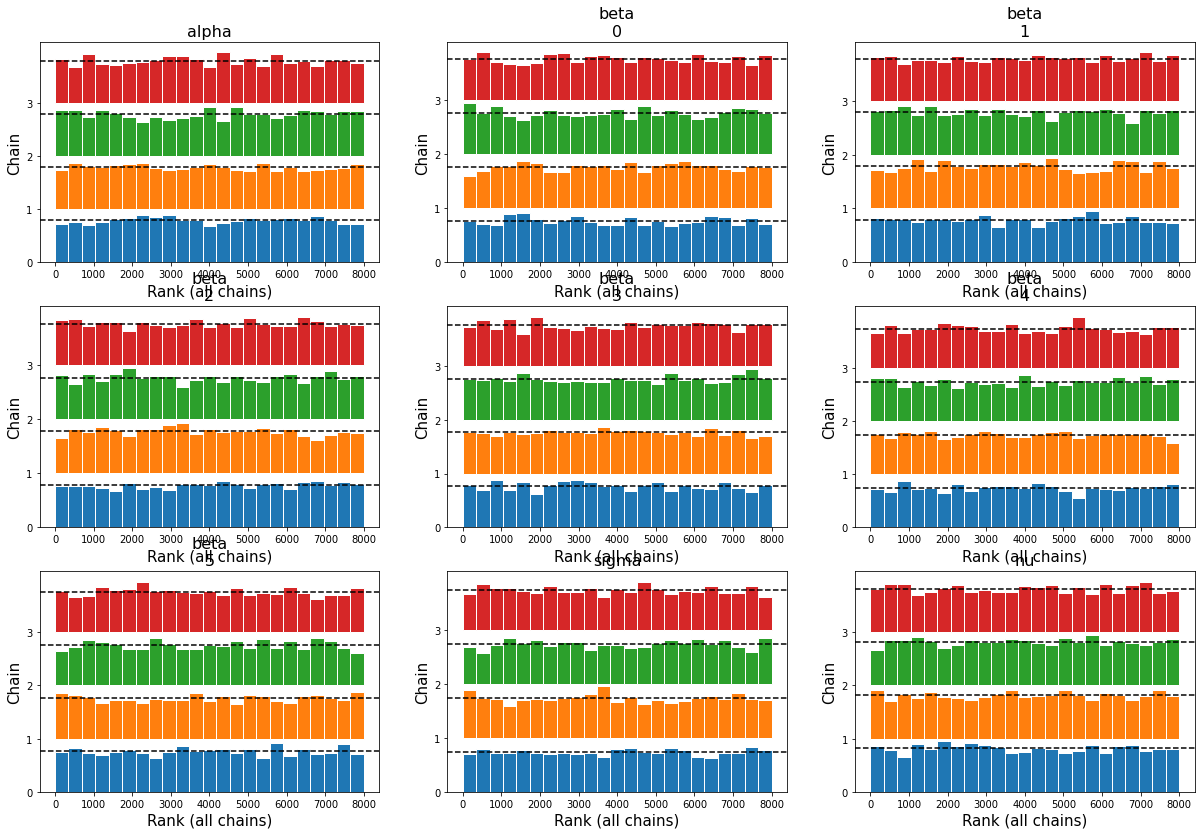

In [279]:
#diagnostic plots
az.plot_rank(trace_m2, varnames)

A look at the rank plots shows that the posterior was evenly explored by all chains across all parameters. When this is the case, the distribution of ranks should be uniform, and this is the case for all chains. There are some subtle cases where some chains did not explore the posterior perfectly, namely $\beta_1$ by chain 3, but the other chains explored $\beta_1$ satisfactorily, so this is a very minor issue. Overall, the rank plot further indicates that the sampling was successful.

array([[<AxesSubplot: ylabel='beta\n0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n1'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n2'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n3'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n4'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n5'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >

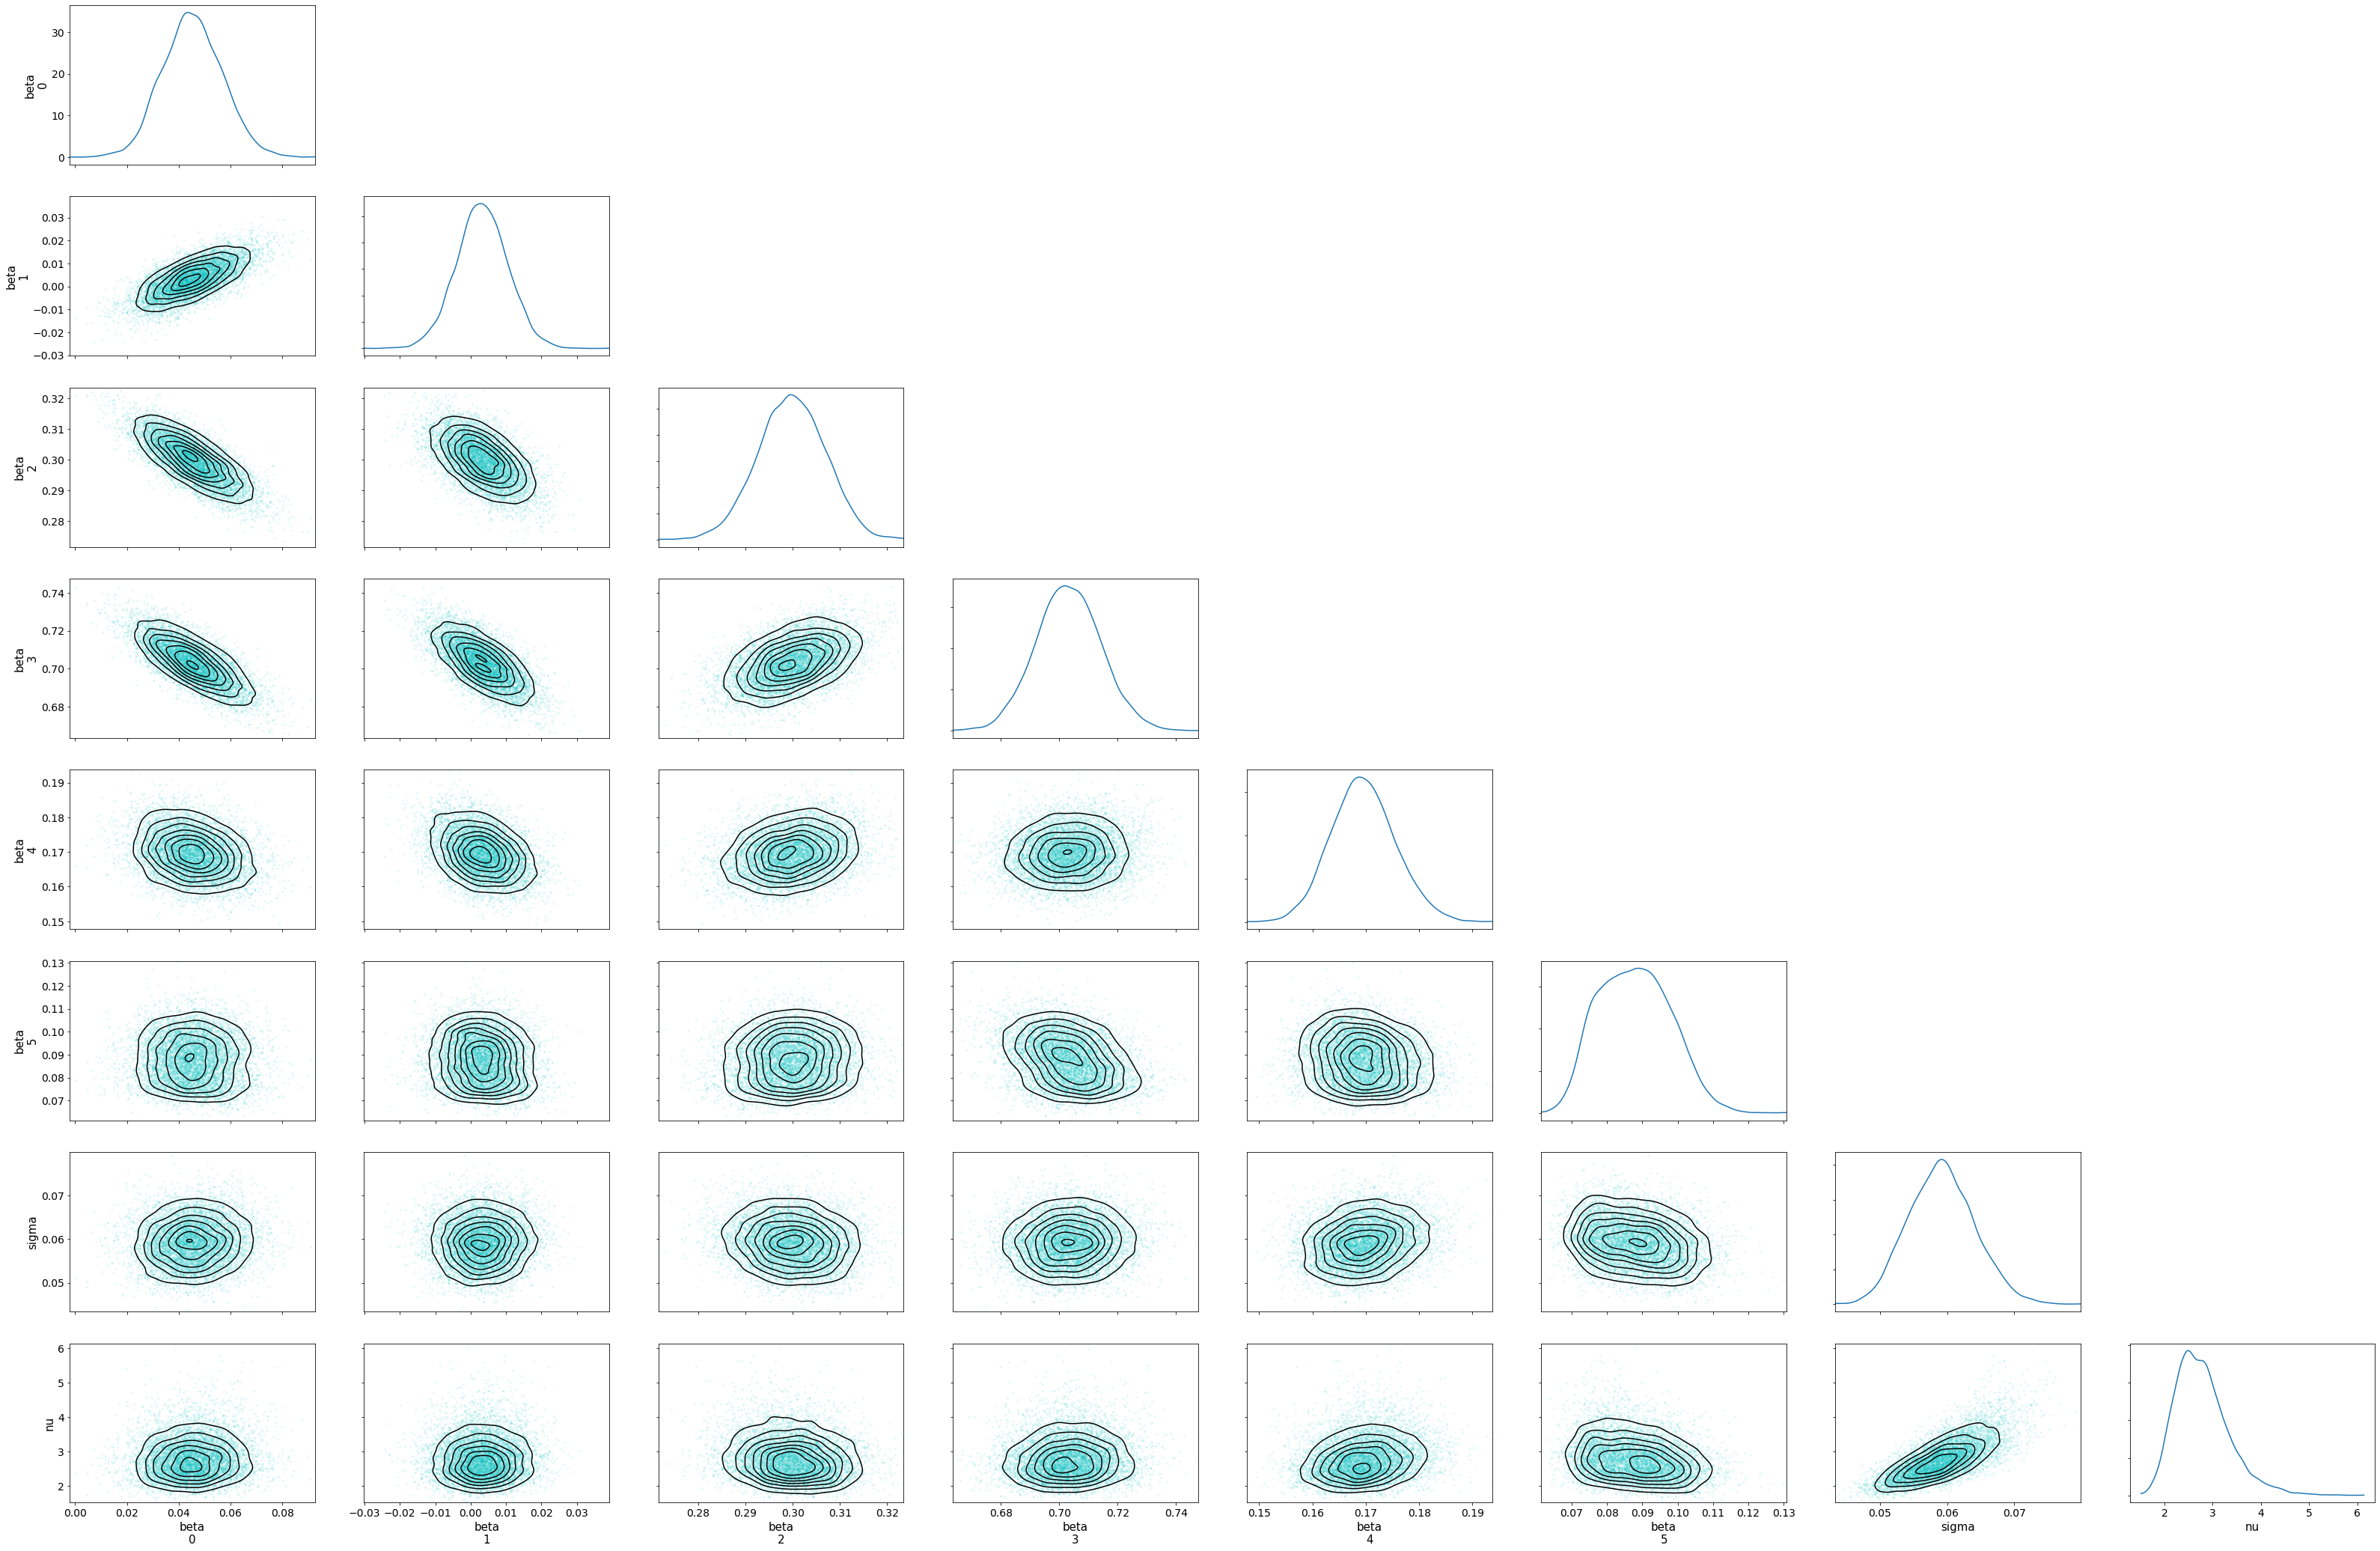

In [280]:
az.plot_pair(trace_m2, 
            var_names = ['~mu','~alpha'],
            marginals = True,
            kind = ['scatter', 'kde'],
            scatter_kwargs={"color": "c", "alpha": 0.1},
            marginal_kwargs={"kind": "kde", "color": "C0"},
            kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}})

The pair plots above match the expectation that the posterior distribution over any two parameters will be approximately symmetric. One plot to focus on is that $\sigma$ vs $\nu$ plot. Notice that $\sigma$ and $\nu$ have a slightly positive relationship: a higher $\sigma$ tends to come with a lower $\nu$. This makes sense as both parameters control the spread of the T distribution, so higher $\sigma$ values create a more spread distribution, which is compensated for by reducing $\nu$. Overall, the pairplots look as expected, and it appears that the model was correctly implemented

Text(0, 0.5, 'Parameter')

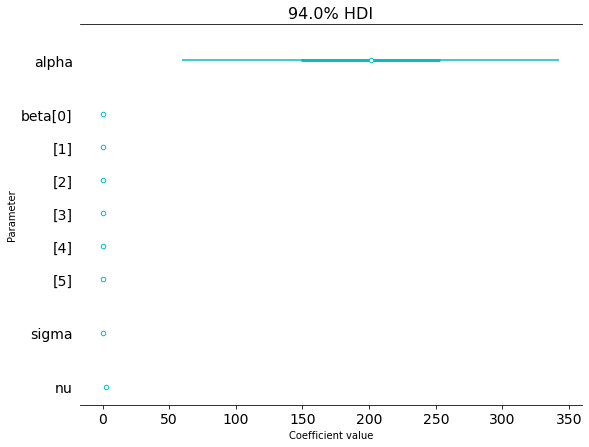

In [281]:
#94% HDIs over the parameters
az.plot_forest(trace_m2, 
              kind = 'forestplot',
               var_names = varnames,
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Coefficient value')
plt.ylabel('Parameter')

In the cell above, only the $\alpha$ HDI is resolvable, and the interval on $\alpha$ is very wide. As previously discussed, this is reflective of the strong effect had by other ions on the conductivity of water, and the uncertainty in $\alpha$ reflects the uncertainty in EC when nothing is known about the chemical composition of the water. 

[Text(0, 0.0, 'Na_std'),
 Text(0, 0.825, 'Ca_std'),
 Text(0, 1.65, 'HCO3_std'),
 Text(0, 2.4749999999999996, 'Cl_std'),
 Text(0, 3.3, 'NO3 _std'),
 Text(0, 4.125, 'SO4_std')]

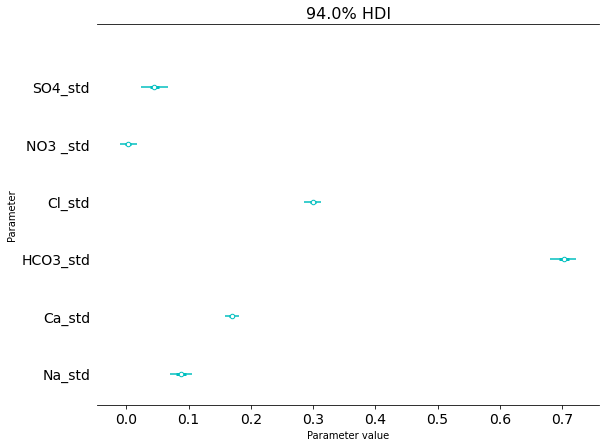

In [282]:
ax = az.plot_forest(trace_m2, 
              kind = 'forestplot',
               var_names = ['~mu','~sigma','~alpha','~nu'],
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Parameter value')
plt.ylabel('Parameter')
ax[0].set_yticklabels(keep)

The HDIs over the $\beta_k$s, like in the previosu model, are all very narrow, and represent the relative impact an increase of one ppm of the solute has on the overall electric conductivity of the water. The narrow HDI tells us that the EC can be estimated with a high degree of precision using data of only these analytes. The HDI for the coefficient for NO3 still dips into the negative, which suggests that this molecule's contribution to EC is still uncertain. It may be better to drop it as a predictor entirely. Nonetheless, this model is similarly advantageous to the first model in terms of flagging samples, thanks to this high precision, but retains the same flaw of the NO3 coefficient. 

Text(0, 0.5, 'Parameter')

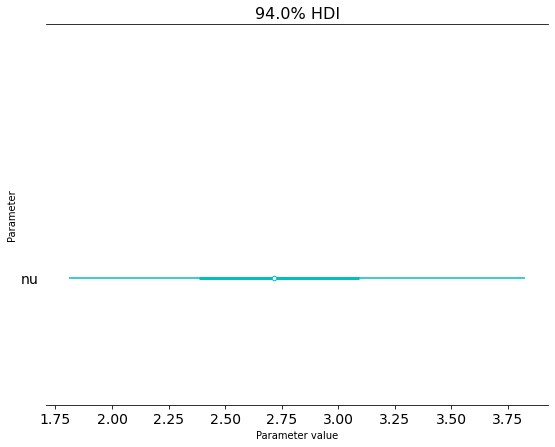

In [283]:
ax = az.plot_forest(trace_m2, 
              kind = 'forestplot',
               var_names = ['nu'],
               combined = True,
               colors = ['c'],
               figsize = (9,7))
plt.xlabel('Parameter value')
plt.ylabel('Parameter')

The HDI over $\nu$ suggests values between 2 and 4 are plausible. This gives us very thick tails and is indicative of their being many outlier points. This means that choosing a T distribution as opposed to a normal distribution will alter the posterior-predictive significantly, as this T distribution has much thicker tails than a normal of the same mean and variance. In the final cell of this part of the notebook, posterior-predictive samples are plotted.

Text(0, 0.5, 'Parameter')

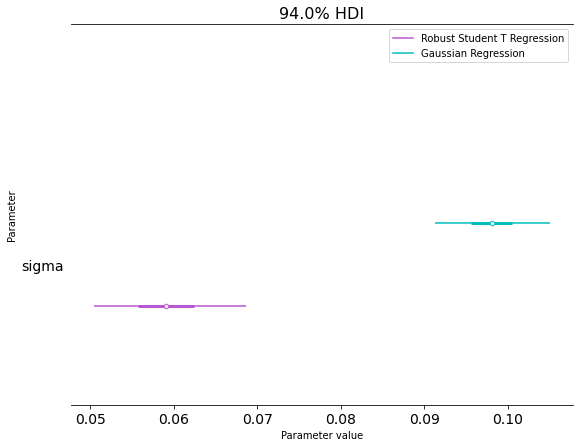

In [284]:
ax = az.plot_forest((trace_m1, trace_m2), 
               kind = 'forestplot',
               model_names = ['Gaussian Regression', 'Robust Student T Regression'],
               var_names = ['sigma'],
               combined = True,
               colors = ['c', 'mediumorchid'],
               figsize = (9,7))
plt.xlabel('Parameter value')
plt.ylabel('Parameter')

In the plot above, the 94\% HDIs over $\sigma$ are plotted for each model. The robust regression gives $\sigma$ values that are consistently smaller than the Gaussian regression, as the HDIs do not overlap. This means that the bulk of the EC distribution sits within a smaller area under the robust regression than under the Gaussian regression, and reduces uncertainty in EC. 

In [285]:
#posterior predictive 

#sampling from the posterior predictive
n_samples = 6 #number of samples to draw 

with m2: 
    pos = pm.sample(6)

#taking posterior samples
samples = [pos.posterior.mu.values.flatten(), pos.posterior.sigma.values.flatten(), 
           pos.posterior.nu.values.flatten()]

Only 6 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 1_000 tune and 6 draw iterations (4_000 + 24 draws total) took 21 seconds.
<ipython-input-285-81275ea9132d>:7: UserWarning: The number of samples is too small to check convergence reliably.
  pos = pm.sample(6)


<ipython-input-286-69fb3f56ffaa>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([np.abs(round(d*water['E.C'].std(), 2)) for d in x])


Text(0.5, 0.98, 'Posterior-predictive samples')

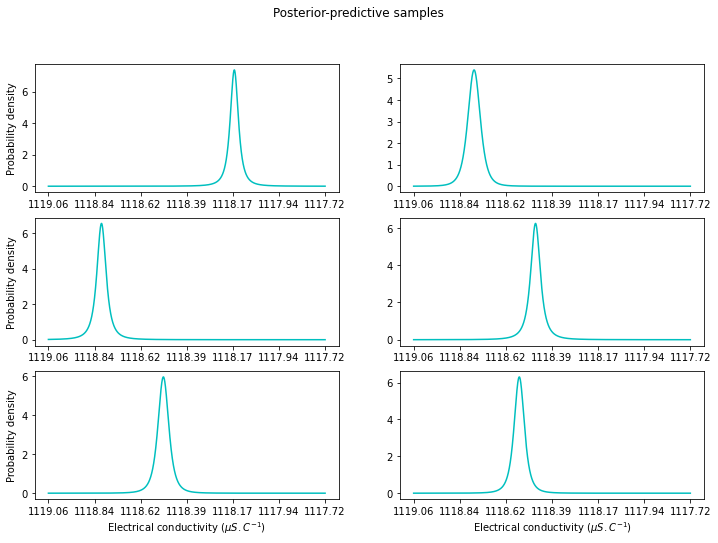

In [286]:
#plotting posterior-predictive normal distributions 
fig, axs = plt.subplots(3,2, figsize = (12,8))
#code adapted from Session 5, PCW notebook, Cell 5
for i in range(n_samples):
    ax = plt.subplot(3,2,i+1)
    m = samples[0][i]
    s = samples[1][i]
    #adding in nu 
    n = samples[2][i]
    
    x = np.linspace(-1.5,1.5, 10000)
    y = sts.t.pdf(x, df = np.round(n), loc = m, scale = s)
    
    plt.plot(x,y, color = 'c')
    
    #changing x scales to absolute values
    if i == 0 or i == 2 or i == 4: 
        plt.ylabel('Probability density')
    if i == 4 or i == 5:
        plt.xlabel('Electrical conductivity ($\mu S.C^{-1}$)')
    ax.set_xticklabels([np.abs(round(d*water['E.C'].std(), 2)) for d in x])
plt.suptitle('Posterior-predictive samples')

The posterior predictive plots above take six samples of the posterior distributions over $\mu$, $\sigma$ and $\nu$ and produce the associated T distributions. These posterior-predictive samples predict electrical conductivity to a high degree of precision. Again, this is ideal for flagging samples, as even a small deviation from the predicted electrical conductivity would be very unlikely as predicted by the posterior-predictive, letting us flag samples with small concentrations of additional solutes for further testing. 

# Model Comparison

The discussion of the two models suggests that both are good for our purpose of flagging samples. The question remains, though, of which is better. The better model will be more precise and have greater predictive power. We can evaluate the relative abilities of each model using PSIS. 

In [287]:
#PSIS model 1
az.loo(trace_m1)

/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   313.84    25.06
p_loo       12.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      353   99.4%
 (0.5, 0.7]   (ok)          1    0.3%
   (0.7, 1]   (bad)         1    0.3%
   (1, Inf)   (very bad)    0    0.0%

In [288]:
#PSIS model 2
az.loo(trace_m2)

Computed from 8000 posterior samples and 355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   351.37    20.77
p_loo       14.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      355  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The PSIS LOO provides an estimate of the models' predictive accuracies. It estimates the leave-one-out cross-validation (CV) score by assigning each data point a weight, which represents how much it impacts the posterior distribution (unlikely data according to the likelihood affect the posterior more than already likely data), and allows us to estimate the CV score without needing to run thousands of models. The higher the ELPD as estimated by PSIS cross-validation, the greater the predictive accuracy and the better the model (remember that we want out model to predict with high accuracy and high precision, so that we can accurately screen samples). With an estimated ELPD of 351, the robust regression model performs, as expected, slightly better than the non-robust version. This is confirmed in the figure below: 

/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

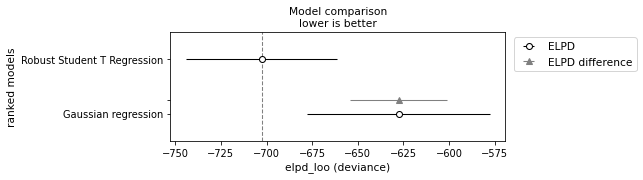

In [289]:
#plotting the comparison 
comparison = az.compare({'Gaussian regression': trace_m1, 
                         'Robust Student T Regression': trace_m2}, ic='loo',
                       scale = 'deviance')
az.plot_compare(comparison)

The robust regression performs better than the Gaussian regression. The plot above compares the estimated deviance computed via PSIS. A lower deviance means that less information was lost by using the robust regression to approximate the true relationship between the predictors and the EC than was lost by using the Gaussian model; a better model has a lower deviance. Note that there is no overlap in the 94% HDI of the deviance of the robust regression and the ELPD difference HDI, indicating that the robust regression is consistently better than the non-robust, Gaussian model. 

Thus for the purpose of screening samples, the robust regression offers more precision and more accuracy than the Gaussian model. The improved precision comes from the lower $\sigma$ values seen under the robust regression, and the greater accuracy has been quantified via PSIS deviance. Improvements could surely be made, e.g. by removing NO3 as a predictor or implementing an outlier detection model. However, the current model is already very accurate and quite precise, meeting the conditions for a model built to flag samples for further analysis.